# 降维

很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，我们接下来就会遇到这种情况。这种问题通常被称为维数灾难（curse of dimentionality）。

## 用途

降维有如下两个用途：

1. 加快训练速度；（仅在训练速度过慢时候考虑）
2. 数据可视化（将数据降低到二维或者三维）。

## 降维方法

1. 投影（projection）：PCA、Kernel PCA
2. 流行学习（Manifold Learning）：LLE

# 主成分分析（PCA）

主成分分析（Principal Component Analysis）是目前为止最流行的降维算法。__首先它找到接近数据集分布的超平面，然后将所有的数据都投影到这个超平面上__。

Scikit-Learn 的 PCA 类使用 SVD 分解来实现。以下代码应用 PCA 将数据集的维度降至两维（请注意，__它会自动处理数据的中心化__）：

```python
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
```

将 PCA 转化器应用于数据集后，可以使用 `components_` 访问每一个主成分（注意，它返回以 PC 作为水平向量的矩阵，因此，如果想要获得第一个主成分则可以写成 `pca.components_.T[:,0]`）。

## 方差解释率

一个非常有用的信息是每个主成分的方差解释率，可通过 `explained_variance_ratio_` 变量获得。__表示位于每个主成分轴上的数据集方差的比例__。

## 选择正确的维度

通常我们倾向于选择加起来到方差解释率能够达到足够占比（例如 95%）的维度的数量，而不是任意选择要降低到的维度数量。

> 当然，除非您正在为数据可视化而降低维度 -- 在这种情况下，通常希望将维度降低到 2 或 3。

通过将 `n_components` 的参数值设置为 0-1 之间的浮点数，表明希望保留的方差比率

```python
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
```

## PCA 压缩

在降维之后，训练集占用的空间要少得多。例如，尝试将 PCA 应用于 MNIST 数据集，同时保留 95% 的方差。你应该发现每个实例只有 150 多个特征，而不是原来的 784 个特征。因此，尽管大部分方差都保留下来，但数据集现在还不到其原始大小的 20%！

通过应用 PCA 投影的逆变换，也可以将缩小的数据集解压缩回 784 维。当然这并不会返回给你最原始的数据，因为投影丢失了一些信息（在5％的方差内），但它可能非常接近原始数据。原始数据和重构数据之间的均方距离（压缩然后解压缩）被称为重构误差（reconstruction error）。

可以通过 `inverse_transform()` 方法进行解压缩。

实例：

![images](./images/Image00473.jpg)

## 增量 PCA（Incremental PCA）

先前 PCA 实现的一个问题是它需要在内存中处理整个训练集以便 SVD 算法运行。幸运的是，我们已经开发了增量 PCA（IPCA）算法：__可以将训练集分批，并一次只对一个批量使用 IPCA 算法__。这对大型训练集非常有用，并且可以在线应用 PCA（即在新实例到达时即时运行）。

下面的代码将 MNIST 数据集分成 100 个小批量（使用 NumPy 的 `array_split()` 函数），并将它们提供给 Scikit-Learn 的 `IncrementalPCA` 类，以将 MNIST 数据集的维度降低到 154 维。请注意，必须对每个最小批次调用 `partial_fit()` 方法，而不是对整个训练集使用 `fit()` 方法：

```python
from sklearn.decomposition import IncrementalPCA

n_batches = 100 
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_spplit(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)

X_mnist_reduced = inc_pca.transform(X_mnist)
```

## 随机 PCA（Randomized PCA）

Scikit-Learn 提供了另一种执行 PCA 的选择，称为随机 PCA。这是一种随机算法，可以快速找到前d个主成分的近似值。它的计算复杂度是 $O(m × d^2) + O(d^3)$，而不是 $O(m × n^2) + O(n^3)$，所以当 d 远小于 n 时，它比之前的算法快得多。

```python
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced=rnd_pca.fit_transform(X_mnist)
```

## 核 PCA（Kernel PCA）

它通常能够很好地保留投影后的簇，有时甚至可以展开分布近似于扭曲流形的数据集。

```python
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
```

### 选择一种核并调整超参数

由于 `kPCA` 是无监督学习算法，因此没有明显的性能指标可以帮助您选择最佳的核方法和超参数值。但是，降维通常是监督学习任务（例如分类）的准备步骤，因此您可以简单地使用网格搜索来选择可以让该任务达到最佳表现的核方法和超参数。

下面的代码创建了一个两步的流水线，首先使用 `kPCA` 将维度降至两维，然后应用 `Logistic` 回归进行分类。然后它使用 `Grid SearchCV` 为 `kPCA` 找到最佳的核和 `gamma` 值，以便在最后获得最佳的分类准确性：

```python
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
     "kpca__gamma" : np.linspace(0.03, 0.05, 10),
     "kpca__kernel" : ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
```

> 默认条件下，`fit_inverse_transform=False` 并且 `KernelPCA` 没有 `inverse_tranfrom()` 方法。这种方法仅仅当 `fit_inverse_transform=True` 的情况下才会创建。

# LLE

局部线性嵌入（Locally Linear Embedding）是另一种非常有效的非线性降维（NLDR）方法。

这是一种流形学习技术，不依赖于像以前算法那样的投影。简而言之，LLE 首先测量每个训练实例与其最近邻（c.n.）之间的线性关系，然后寻找能最好地保留这些局部关系的训练集的低维表示。这使得它特别擅长展开扭曲的流形，尤其是在没有太多噪音的情况下。

实例：

```python
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)
```

# 其他降维方法

还有很多其他的降维方法，Scikit-Learn 支持其中的好几种。这里是其中最流行的：

* 多维缩放（MDS）在尝试保持实例之间距离的同时降低了维度（参见下图）
* Isomap 通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维度。
* t-分布随机邻域嵌入（t-Distributed Stochastic Neighbor Embedding，t-SNE）可以用于降低维度，同时试图保持相似的实例临近并将不相似的实例分开。__它主要用于可视化，尤其是用于可视化高维空间中的实例__（例如，可以将MNIST图像降维到 2D 可视化）。
* 线性判别分析（Linear Discriminant Analysis，LDA）实际上是一种分类算法，但在训练过程中，它会学习类之间最有区别的轴，然后使用这些轴来定义用于投影数据的超平面。LDA 的好处是投影会尽可能地保持各个类之间距离，所以在运行另一种分类算法（如 SVM 分类器）之前，LDA 是很好的降维技术。

![images](./images/Image00103.jpg)

In [6]:
# 使用 t-SNE 可视化 MNIST 数据集

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

<Figure size 432x288 with 0 Axes>

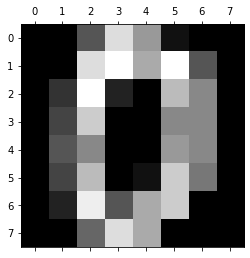

In [18]:
plt.gray()
plt.matshow(digits['data'][0].reshape(8, 8))
# plt.matshow(digits.images[0])
plt.show()

In [21]:
from sklearn.manifold import TSNE

X = digits['data']
tsne = TSNE(n_components=2)
X_2D = tsne.fit_transform(X)

In [24]:
y = digits['target']

In [34]:
x = X_2D[:10, 1:2]
y = X_2D[:10, 1:2]

array([[-39.389088 ],
       [  3.6044602],
       [ 13.109082 ],
       [ 25.718252 ],
       [ -1.0664079],
       [ 13.097607 ],
       [-49.476505 ],
       [ 50.85965  ],
       [ 10.572321 ],
       [  9.416449 ]], dtype=float32)

In [31]:
plt.scatter(X_2D[:10])

TypeError: scatter() missing 1 required positional argument: 'y'